# Housing Prices: Gradient Boosting Fine-Tuning and Optimization

**Date:** 2025-11-02  
**Author:** *Luis Renteria Lezano*

## Executive Summary
- **Goal:** Perform advanced hyperparameter tuning and optimization of a Gradient Boosting Regressor to improve predictive performance on house sale prices.  
- **Source:** Based on the cleaned and engineered dataset from the previous EDA stage [`/01_eda_and_feature_engineering.ipynb`](./01_eda_and_feature_engineering.ipynb).  
- **Data:** [`../data/interim/features_cleaned.csv`](../data/interim/features_cleaned.csv)  
- **Scope:** This notebook focuses exclusively on the Gradient Boosting model, exploring hyperparameter tuning, learning curves, feature importance, and residual analysis to identify the best-performing configuration.


## 0. Reproducibility & Environment Setup
- Pin versions in [`../requirements.txt`](../).
- Keep raw data immutable [`../data/raw/`](../data/raw/).
- Export model outputs (metrics, predictions, feature importance) tables to [`../reports/tables/`](../reports/tables/) and figures to [`../reports/figures/gradient_boosting`](../reports/figures/gradient_boosting).

In [1]:
#  Imports & basic setup
import os
import sys
import joblib
from time import time
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, cross_val_score
from sklearn.metrics import root_mean_squared_error, r2_score

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor

# Reproducibility
SEED = 42
np.random.seed(SEED)

# Load Script
sys.path.append('../src')
from build_features import build_features

# Paths
DATA_RAW = Path('../data/raw')
DATA_INTERIM = Path('../data/interim')
DATA_PROCESSED = Path('../data/processed/gradient_boosting')
REPORTS_TABLES = Path('../reports/tables')
REPORTS_FIGURES = Path('../reports/figures/gradient_boosting')
MODELS = Path('../models')

# Create directories if missing
for folder in [DATA_RAW, DATA_INTERIM, DATA_PROCESSED, REPORTS_TABLES, REPORTS_FIGURES, MODELS]:
    folder.mkdir(parents=True, exist_ok=True)

# Plot themes and palettes defaults
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.facecolor'] = '#fafafa'
plt.rcParams['grid.alpha'] = 0.3
sns.set_theme(style='whitegrid', palette='colorblind', context='notebook')

print('Folder statuses:')
for d in [DATA_RAW, DATA_INTERIM, DATA_PROCESSED, REPORTS_TABLES, REPORTS_FIGURES]:
    print(f"\t./{d.as_posix()} - {'Ready' if d.exists() else 'Missing'}")
print('> Environment setup completed.')

Folder statuses:
	./../data/raw - Ready
	./../data/interim - Ready
	./../data/processed/gradient_boosting - Ready
	./../reports/tables - Ready
	./../reports/figures/gradient_boosting - Ready
> Environment setup completed.


## 1. Introduction

This notebook focuses on fine-tuning and evaluating a Gradient Boosting Regressor to predict house sale prices using the processed Ames Housing dataset.
The data was cleaned and engineered in the previous notebook, ensuring consistent and ready to model inputs: [`../data/interim/features_cleaned.csv`](../data/interim/features_cleaned.csv)

**Purposes of this Notebook**

1. Perform advanced hyperparameter tuning and optimization of the Gradient Boosting model.
2. Evaluate model performance using cross-validation (RMSE, R²) and learning curves.
3. Analyze feature importance to refine future feature engineering.
4. Generate and export final predictions for the Kaggle test set.


## 2. Load Processed Data & Overview

In [2]:
columns_available = pd.read_csv(REPORTS_TABLES / 'feature_descriptions.csv')
columns_available

,Feature,Type,Origin,Description
0,MSZoning,object,raw/encoded,Zoning type
1,Neighborhood,object,raw/encoded,Neighborhood area
2,HouseStyle,object,raw/encoded,House style
3,Exterior1st,object,raw/encoded,Exterior material
4,Foundation,object,raw/encoded,Foundation type
5,BsmtExposure,object,raw/encoded,Basement exposure type
6,GarageType,object,raw/encoded,Garage location
7,GarageFinish,object,raw/encoded,Garage finish
8,MoSold_cat,object,engineered,Month sold (Jan to Dec)
9,MSSubClass,int64,raw/encoded,Type of house sold


In [3]:
df = pd.read_csv(DATA_INTERIM / 'features_cleaned.csv')
df.head(3)

,MSZoning,Neighborhood,HouseStyle,Exterior1st,Foundation,BsmtExposure,GarageType,GarageFinish,MoSold_cat,MSSubClass,...,Age,PorchSF,ComponentsQual,HasBsmt,HasGarage,Has2ndFloor,HasPool,Remodeled,SalePrice,SalePrice_log
0,RL,CollgCr,2Story,VinylSd,PConc,No,Attchd,RFn,Feb,60,...,5,61,3.625,1,1,1,0,0,208500,12.247699
1,RL,Veenker,1Story,MetalSd,CBlock,Gd,Attchd,RFn,May,20,...,31,0,3.375,1,1,0,0,0,181500,12.109016
2,RL,CollgCr,2Story,VinylSd,PConc,Mn,Attchd,RFn,Sep,60,...,7,42,3.625,1,1,1,0,1,223500,12.317171


In [4]:
X = df.drop(['SalePrice', 'SalePrice_log'], axis=1)
y = df['SalePrice_log']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

X_train.to_csv(DATA_PROCESSED / 'X_train.csv', index=False)
X_test.to_csv(DATA_PROCESSED / 'X_test.csv', index=False)
y_test.to_csv(DATA_PROCESSED / 'y_train.csv', index=False)
y_test.to_csv(DATA_PROCESSED / 'y_test.csv', index=False)

print('Train and Test sets saved.')
print(f'''> Training set has: {X_train.shape[0]} samples
> Test set has: {X_test.shape[0]} samples
> # of features: {len(X_test.columns)}''')

Train and Test sets saved.
> Training set has: 1093 samples
> Test set has: 365 samples
> # of features: 30


## 3. Preprocesssing  
Ordinal features were already encoded during feature engineering in the previous notebook and the function retrieved in `../src/build_features.py`. Therefore, in this preprocessing pipeline, only imputation and one-hot encoding (OHE) will be applied.

In [5]:
num_cols = X_train.select_dtypes(['number', 'int64', 'float64']).columns
cat_cols = X_train.select_dtypes(['object', 'string']).columns

print(f'Numerical Features ({len(num_cols)}): {num_cols.tolist()}\n')
print(f'Categorical Features ({len(cat_cols)}): {cat_cols.tolist()}')

Numerical Features (21): ['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'WoodDeckSF', 'BsmtFinType1_ord', 'TotalSF', 'TotalBathrooms', 'Age', 'PorchSF', 'ComponentsQual', 'HasBsmt', 'HasGarage', 'Has2ndFloor', 'HasPool', 'Remodeled']

Categorical Features (9): ['MSZoning', 'Neighborhood', 'HouseStyle', 'Exterior1st', 'Foundation', 'BsmtExposure', 'GarageType', 'GarageFinish', 'MoSold_cat']


In [6]:
# Numerical Pipeline
num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median'))
])

# Categorical Pipeline
cat_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Column Transformer
preprocessor = ColumnTransformer([
    ('numerical', num_pipeline, num_cols),
    ('categorical', cat_pipeline, cat_cols)
])

## 4. Hyperparameter Optimization

In [7]:
model = GradientBoostingRegressor(random_state=SEED)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

param_grid = {
    'model__n_estimators': [700, 800, 900],  
    'model__learning_rate': [0.020, 0.024, 0.028, 0.032], 
    'model__max_depth': [3],
    'model__subsample': [0.8],  
    'model__min_samples_split': [5, 10],  
    'model__min_samples_leaf': [2, 3, 4],
    'model__max_features': ['sqrt', None]
}

scoring = {
    'RMSE': 'neg_root_mean_squared_error',
    'R2': 'r2'
}

kf = KFold(n_splits=10, shuffle=True, random_state=SEED)
cv = GridSearchCV(pipeline, param_grid, scoring=scoring, refit='RMSE', n_jobs=-1, cv=kf)

time_start = time()
cv.fit(X_train, y_train)
time_stop = time()

print(f'> Model trained in {time_stop-time_start:.2f} seconds.\nBest RMSE (CV): {-1*cv.best_score_:.3f}')

> Model trained in 246.21 seconds.
Best RMSE (CV): 0.118


## 5. Fine-Tuning

In [8]:
pd.set_option('display.max_colwidth', None)
# Best params, sorted by the best neg_rmse result
pd.DataFrame(cv.cv_results_).sort_values('mean_test_RMSE', ascending=False).loc[:, ['params', 'mean_test_RMSE', 'mean_test_R2']].head(1)

,params,mean_test_RMSE,mean_test_R2
73,"{'model__learning_rate': 0.028, 'model__max_depth': 3, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 800, 'model__subsample': 0.8}",-0.117812,0.907666


In [9]:
param_grid_fine = {
    'model__learning_rate': [0.024, 0.026, 0.028, 0.030],
    'model__n_estimators': [750, 800, 850, 900, 950, 1000],
    'model__min_samples_leaf': [2, 3],
    'model__min_samples_split': [5, 7, 10],
    'model__subsample': [0.7, 0.8, 0.9],
    'model__max_features': ['sqrt', 'log2'],
    'model__max_depth': [3]
}

scoring = {
    'RMSE': 'neg_root_mean_squared_error',
    'R2': 'r2'
}

kf = KFold(n_splits=10, shuffle=True, random_state=SEED)
cv_fine = GridSearchCV(pipeline, param_grid_fine, scoring=scoring, refit='RMSE', n_jobs=-1, cv=kf)

time_start = time()
cv_fine.fit(X_train, y_train)
time_stop = time()

print(f'> Fine-tuned model trained in {time_stop - time_start:.2f} seconds.\n'
      f'Best RMSE (CV): {-cv_fine.best_score_:.3f}')

> Fine-tuned model trained in 668.97 seconds.
Best RMSE (CV): 0.117


In [10]:
pd.DataFrame(cv_fine.cv_results_).sort_values('mean_test_RMSE', ascending=False).loc[:, ['params', 'mean_test_RMSE', 'mean_test_R2']].head(1)

,params,mean_test_RMSE,mean_test_R2
232,"{'model__learning_rate': 0.026, 'model__max_depth': 3, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 1000, 'model__subsample': 0.8}",-0.11724,0.908738


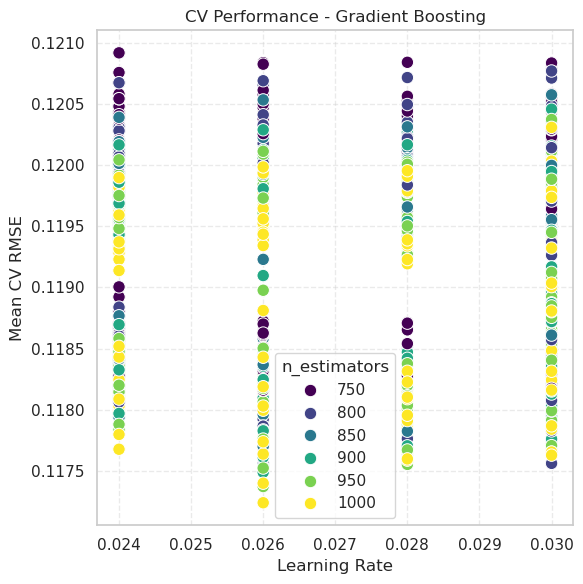

In [11]:
results = pd.DataFrame(cv_fine.cv_results_)

plt.figure(figsize=(6,6))
sns.scatterplot(data=results, x='param_model__learning_rate', y=-results['mean_test_RMSE'], hue='param_model__n_estimators', palette='viridis', s=80)
plt.title('CV Performance - Gradient Boosting')
plt.xlabel('Learning Rate')
plt.ylabel('Mean CV RMSE')
plt.legend(title='n_estimators')
plt.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.savefig(REPORTS_FIGURES / '01_cv_performance_gradient_boosting.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Model Evaluation

In [12]:
y_pred = cv_fine.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'The RMSE and R² TRAIN scores are: {-cv_fine.best_score_:.4f} | {cv_fine.cv_results_['mean_test_R2'].max()*100:.2f}%')
print(f'The RMSE and R² TEST scores are: {rmse:.4f} | {r2*100:.2f}%')

The RMSE and R² TRAIN scores are: 0.1172 | 90.87%
The RMSE and R² TEST scores are: 0.1126 | 92.20%


In [13]:
y_pred = cv_fine.predict(X_test)

y_test_real = np.expm1(y_test)
y_pred_real = np.expm1(y_pred)

rmse_real = root_mean_squared_error(y_test_real, y_pred_real)
r2_real = r2_score(y_test_real, y_pred_real)

print(f"The RMSE and R² TEST scores (real scale): {rmse_real:.2f} | {r2_real*100:.2f}%")

The RMSE and R² TEST scores (real scale): 23130.06 | 91.27%


## 7. Feature Importance

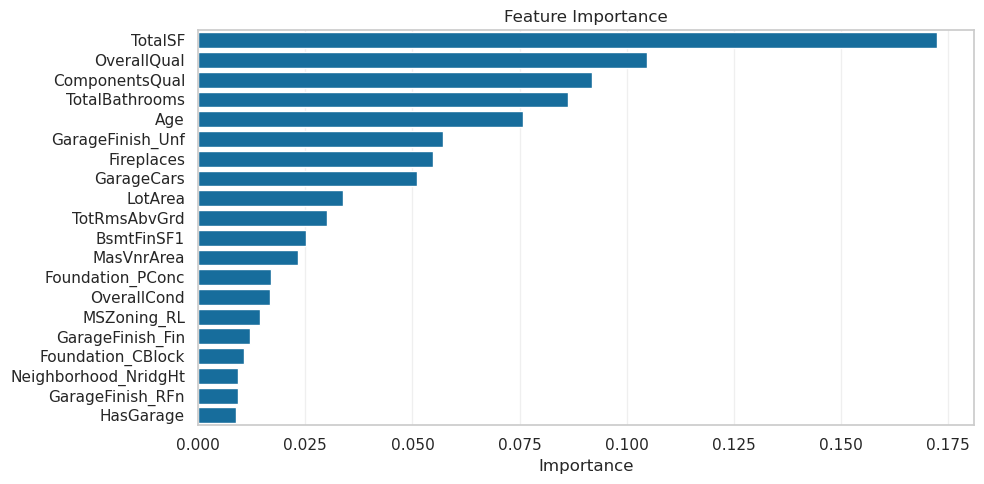

In [14]:
best_model = cv.best_estimator_['model']
importances = best_model.feature_importances_
feature_names = cv.best_estimator_['preprocessor'].get_feature_names_out()
names = []
for name in feature_names:
    if name.startswith('numerical__'):
        name = name.replace('numerical__', '')
        names.append(name)
    elif name.startswith('categorical__'):
        name = name.replace('categorical__', '')
        names.append(name)
    else:
        names.append(name)
        
importance_df = pd.DataFrame({'Feature': names, 'Importances': importances}).sort_values('Importances', ascending=False).head(20)

ax = sns.barplot(data=importance_df, x='Importances', y='Feature')
ax.set(xlabel='Importance', ylabel='', title='Feature Importance')

plt.tight_layout()
plt.savefig(REPORTS_FIGURES / '02_feature_importances.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Comparison with Previous Models

Load the final voting model from the notebook [02_voting_ensemble.ipynb](./02_voting_ensemble.ipynb) to compare results.

In [15]:
voting_model = joblib.load(MODELS / 'voting_regressor.pkl')
gb_model = cv_fine.best_estimator_ 

In [16]:
# voting ensemble
y_pred_voting = voting_model.predict(X_test)
rmse_voting = root_mean_squared_error(y_test, y_pred_voting)
r2_voting = r2_score(y_test, y_pred_voting)

# gradient boosting (fine tuned)
y_pred_gb = gb_model.predict(X_test)
rmse_gb = root_mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f"Voting → RMSE: {rmse_voting:.4f}, R²: {r2_voting:.4f}")
print(f"GB Fine-tuned → RMSE: {rmse_gb:.4f}, R²: {r2_gb:.4f}")

Voting → RMSE: 0.1138, R²: 0.9203
GB Fine-tuned → RMSE: 0.1126, R²: 0.9220


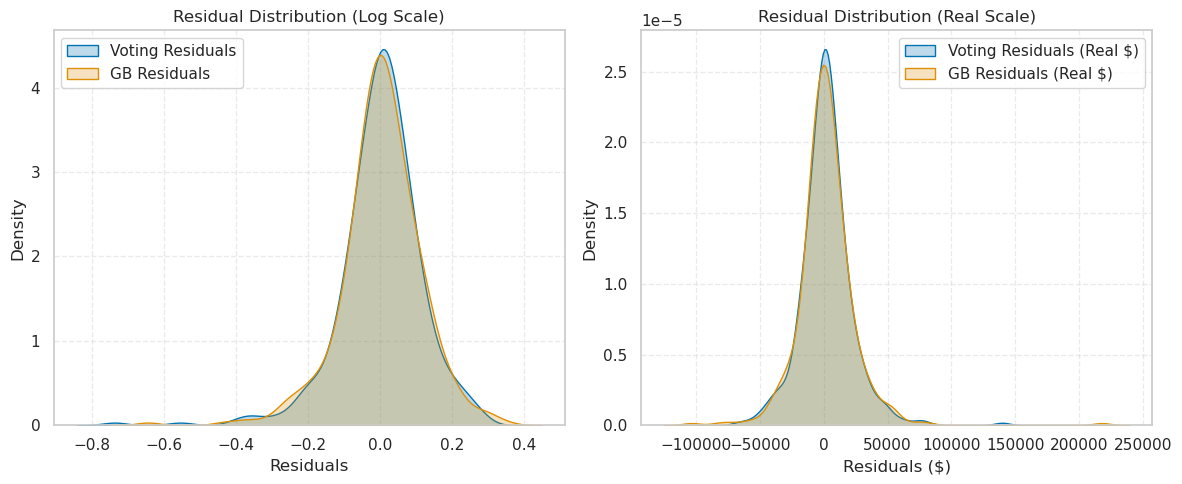

In [17]:
y_test_real = np.expm1(y_test)
y_pred_voting_real = np.expm1(y_pred_voting)
y_pred_gb_real = np.expm1(y_pred_gb)

residuals_voting_real = y_test_real - y_pred_voting_real
residuals_gb_real = y_test_real - y_pred_gb_real

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.kdeplot(y_test - y_pred_voting, label='Voting Residuals', fill=True, ax=axes[0])
sns.kdeplot(y_test - y_pred_gb, label='GB Residuals', fill=True, ax=axes[0])
axes[0].set_title('Residual Distribution (Log Scale)')
axes[0].set_xlabel('Residuals')
axes[0].grid(True, linestyle='--', alpha=0.4)
axes[0].legend()

sns.kdeplot(residuals_voting_real, label='Voting Residuals (Real $)', fill=True, ax=axes[1])
sns.kdeplot(residuals_gb_real, label='GB Residuals (Real $)', fill=True, ax=axes[1])
axes[1].set_title('Residual Distribution (Real Scale)')
axes[1].set_xlabel('Residuals ($)')
axes[1].grid(True, linestyle='--', alpha=0.4)
axes[1].legend()

plt.tight_layout()
plt.savefig(REPORTS_FIGURES / '03_residual_distribution_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [18]:
# 95 percentile is the most representative to measure model generalization, shows that is strong against outliers
print(f'GB residuals: {np.percentile(np.abs(y_test - y_pred_gb), [90, 95, 99])}')
print(f'Voting residuals: {np.percentile(np.abs(y_test - y_pred_voting), [90, 95, 99])}')

GB residuals: [0.18182596 0.23189628 0.34844867]
Voting residuals: [0.18702976 0.2266407  0.35994662]


**Important Insight:**  
Both models show very similar residual spreads, but Gradient Boosting has slightly smaller typical errors (90th and 99th percentiles) while Voting performs a bit better around the 95th percentile, reinforcing that GB fits a bit tighter overall, yet Voting handles mid-range errors more smoothly.


## 9. Conclusion and Next Steps
**Conclusions**

* Cross-validation improved from 0.118 to 0.117 after fine-tuning, confirming stability and good generalization.
* Key hyperparameters were `learning_rate = 0.026` and `n_estimators = 1000`, balancing learning speed and model depth.
* No scaling or log transformations were required, as Gradient Boosting is a tree-based model and handles raw feature distributions naturally.
* Feature importance results aligned with the EDA, highlighting `TotalSF`, `OverallQual`, and `ComponentsQual` as the most influential predictors.
* The fine-tuned Gradient Boosting Regressor achieved an RMSE of 0.1126 and R² of 0.9220 on the test set, slightly outperforming the Voting Ensemble (RMSE 0.1138, R² 0.9203), the log-scale plot shows both models with nearly identical residual distributions but...
* When converted back to real dollar values, Gradient Boosting’s few larger errors become magnified, raising its RMSE, confirming that while GB fits slightly better in log terms, the Voting Ensemble remains more robust and consistent in real price predictions.

**Next Steps**

1. Test other boosting variants such as XGBoost or LightGBM for faster training and possible small gains.
2. Explore Optuna or Bayesian optimization for more efficient hyperparameter tuning.
3. Evaluate stacking or blending the fine-tuned Gradient Boosting with other strong learners.

# 10. Exporting Model

In [19]:
print('Exporting results...')
joblib.dump(cv_fine, MODELS / 'gradient_boosting.pkl')
print('Model saved to gradient_boosting.pkl')

Exporting results...
Model saved to gradient_boosting.pkl


In [20]:
X_competition_raw = pd.read_csv(DATA_RAW / 'test.csv')
X_competition = build_features(X_competition_raw)
y_competition_log = cv_fine.predict(X_competition)
y_competition = np.expm1(y_competition_log)

pd.DataFrame({'Id': pd.read_csv(DATA_RAW / 'test.csv')['Id'], 'SalePrice': y_competition}).to_csv(DATA_PROCESSED / 'submission.csv', index=False)
print('Competition submission.csv saved.')

Competition submission.csv saved.
